In [1]:
import torch
import torchvision.transforms as transforms
import timm
from tqdm import tqdm
from torch.utils.data import Dataset, Subset, DataLoader, Sampler
import glob
import os
from PIL import Image
from collections import defaultdict, Counter
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
import json
import math

os.environ["LOKY_MAX_CPU_COUNT"] = "6"

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

2.6.0+cu126


Andesite  :	43802
Basalt    :	26810
Etc       :	15935
Gneiss    :	73914
Granite   :	92923
Mud_Sandstone:	89467
Weathered_Rock:	37169


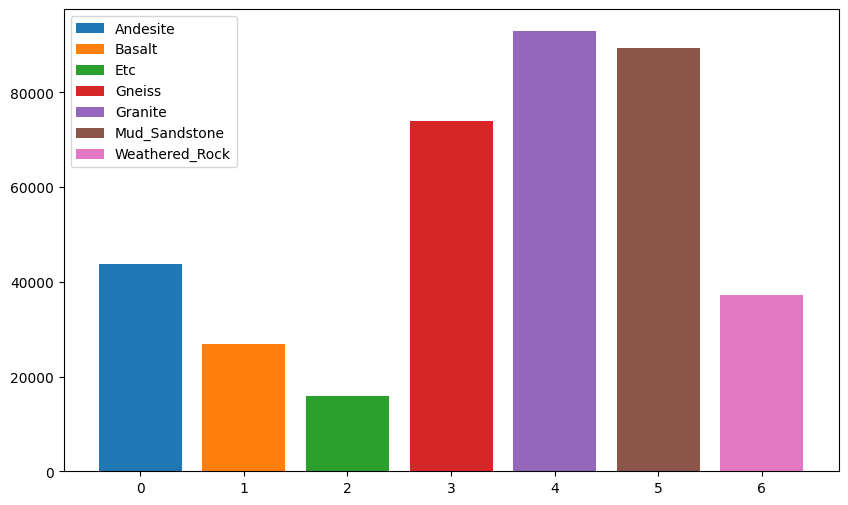

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for index, folder_name in enumerate(glob.glob(r'C:\Users\user\Downloads\open\open\train\*')):
    plt.bar(index, len(glob.glob(f'{folder_name}\\*')), label=os.path.basename(folder_name))
    print(f"{os.path.basename(folder_name):<10s}:\t{len(glob.glob(f'{folder_name}\\*'))}")

plt.legend()
plt.show()

In [4]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.epoch = 60

        self.image_size = (224, 224)
        self.lr = 0.00005
        self.weight_decay = 0.001
    
        self.train_data_dir = r'C:\Users\user\Downloads\open\open\train'
        self.test_data_dir = r'C:\Users\user\Downloads\open\open\test'
        self.test_size = 0.2
        self.batch_size = 36
        self.sample_num = 8000

        self.visualize_epoch = 5
        self.visualize_save_dir = os.path.join(os.getcwd(), 'visualized_features')

config = Config()

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [6]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, z_i, z_j, z_label=None):
        batch_size = z_i.size(0)
        
        z = torch.cat([z_i, z_j], dim=0)
        z = F.normalize(z, dim=1)
        
        sim_matrix = torch.matmul(z, z.T) / self.temperature
        sim_matrix = sim_matrix - torch.max(sim_matrix, dim=1, keepdim=True)[0]

        labels = z_label.repeat_interleave(2)
        mask = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1)).float().to(z_i.device)
        mask.fill_diagonal_(0)

        logits_mask = ~torch.eye(2 * batch_size, dtype=torch.bool).to(z_i.device)
        exp_sim = torch.exp(sim_matrix) * logits_mask

        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-12)
        log_prob = log_prob * logits_mask

        loss = -(mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-12)
        # loss = -loss.mean()

        return loss

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        targets = targets.view(-1, 1)

        log_p = log_probs.gather(1, targets).squeeze(1)
        p_t = probs.gather(1, targets).squeeze(1)

        if self.alpha is not None:
            if isinstance(self.alpha, (list, torch.Tensor)):
                alpha_t = self.alpha[targets.squeeze()]
            else:
                alpha_t = self.alpha
            loss = -alpha_t * (1 - p_t) ** self.gamma * log_p
        else:
            loss = -(1 - p_t) ** self.gamma * log_p

        return loss

In [8]:
class StratifiedBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = np.array(labels)
        self.batch_size = batch_size

        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)

        self.class_ratios = {
            label: len(idxs) / len(self.labels)
            for label, idxs in self.label_to_indices.items()
        }

        self.label_queues = {
            label: [] for label in self.label_to_indices
        }

        self._reset_label_queues()
        self.batches = self._create_batches()

    def _reset_label_queues(self):
        for label in self.label_to_indices:
            indices = self.label_to_indices[label]
            random.shuffle(indices)
            self.label_queues[label].extend(indices)

    def _create_batches(self):
        batches = []
        current_batch = []

        total_samples = len(self.labels)
        num_batches = math.ceil(total_samples / self.batch_size)

        for _ in range(num_batches):
            batch = []
            for label, ratio in self.class_ratios.items():
                n_samples = int(round(ratio * self.batch_size))

                # refill if empty
                if len(self.label_queues[label]) < n_samples:
                    remaining = self.label_to_indices[label][:]
                    random.shuffle(remaining)
                    self.label_queues[label].extend(remaining)

                for _ in range(n_samples):
                    if self.label_queues[label]:
                        batch.append(self.label_queues[label].pop())

            # 보정: 너무 작거나 클 경우
            if len(batch) > self.batch_size:
                batch = random.sample(batch, self.batch_size)
                
            elif len(batch) < self.batch_size:
                # 부족하면 다른 클래스에서 추가
                extra = self.batch_size - len(batch)
                flat_pool = sum(self.label_queues.values(), [])
                random.shuffle(flat_pool)
                batch += flat_pool[:extra]
                for idx in batch[-extra:]:
                    label = self.labels[idx]
                    if idx in self.label_queues[label]:
                        self.label_queues[label].remove(idx)

            batches.append(batch)

        return batches

    def __iter__(self):
        random.shuffle(self.batches)
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [9]:
class custom_model(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()

        if isinstance(backbone, str):
            self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0)
        elif isinstance(backbone, nn.Module):
            self.backbone = backbone
        else:
            raise

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            num_features = self.backbone(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(num_features, 2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 256),
            nn.GELU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, return_features=False):
        features = self.backbone(x)

        if return_features:
            return self.head(features), features
        
        return self.head(features)
    
    def forward_features(self, x):
        return self.backbone(x)

In [10]:
item_list = glob.glob(rf"{config.train_data_dir}\*\*")
len(item_list)

380020

In [11]:
_num_classes = len(glob.glob(rf"{config.train_data_dir}\*"))
_num_classes

7

In [12]:
# _backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
_backbone = torch.load('backbone.pt', weights_only=False, map_location='cpu')

model = custom_model(_backbone, _num_classes).to(config.device)
model

custom_model(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='non

In [13]:
train_transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.41427545, 0.40396059, 0.39235218], 
                         std=[0.17746354, 0.17282704, 0.16986775])
])

valid_transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.41427545, 0.40396059, 0.39235218], 
                         std=[0.17746354, 0.17282704, 0.16986775])
])

In [14]:
class custom_dataset(Dataset):
    def __init__(self, image_path_set, label_list, transform):
        # self.image_paths = [path for path, label in image_path_set]
        # self.labels = [label for path, label in image_path_set]
        self.image_paths = [path for path in image_path_set]
        self.labels = [os.path.basename(os.path.dirname(path)) for path in image_path_set]

        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        _image_path = self.image_paths[index]
        _image_label = self.label_list.index(self.labels[index])

        _image = Image.open(_image_path)
        _image_1 = self.transform(_image)
        _image_2 = self.transform(_image)

        return (_image_1, _image_2), _image_label, _image_path

In [15]:
class custom_data_factory():
    def __init__(self, paths, sample_num, train_transform, valid_transform):
        # self.paths = [(path, os.path.basename(os.path.dirname(path))) for path in paths]
        self.path_dict = {}
        for path in paths:
            _class = os.path.basename(os.path.dirname(path))
            if self.path_dict.get(_class) == None:
                self.path_dict[_class] = []

            self.path_dict[_class].append(path)

        self.selected_items = {_label: random.choices(_path_list, k=min(len(_path_list), sample_num)) for _label, _path_list in self.path_dict.items()}

        self.label_list = list(self.path_dict.keys())

        self.sample_num = sample_num
        self.train_transform = train_transform
        self.valid_transform = valid_transform

        self.losses = []

    def get_data_set(self):
        _item_list =  sum(self.selected_items.values(), [])
        random.shuffle(_item_list)

        train_index_set, valid_index_set = train_test_split(
            _item_list,
            test_size=config.test_size,
            stratify=sum([[_label] * len(_path_list) for _label, _path_list in self.selected_items.items()], []),
            shuffle=True,
            random_state=42
        )
        
        self.train_set = custom_dataset(train_index_set, self.label_list, self.train_transform)
        self.valid_set = custom_dataset(valid_index_set, self.label_list, self.valid_transform)

        print(f'Train set: {Counter(self.train_set.labels)}')
        print(f'Valid set: {Counter(self.valid_set.labels)}')

        return self.train_set, self.valid_set
    
    def get_data_loader(self):
        train_loader = DataLoader(
            self.train_set, pin_memory=True, 
            batch_sampler=StratifiedBatchSampler(
                [self.label_list.index(_label) for _label in self.train_set.labels], 
                batch_size=config.batch_size
            )
        )

        valid_loader = DataLoader(
            self.valid_set, pin_memory=True,
            batch_sampler=StratifiedBatchSampler(
                [self.label_list.index(_label) for _label in self.valid_set.labels], 
                batch_size=config.batch_size
            )
        )

        return train_loader, valid_loader
    
    def collect_losses(self, _paths, _labels, _losses):
        for _path, _label, _loss in zip(_paths, _labels, _losses):
            self.losses.append((_path, _label.item(), _loss.item()))

    def renew_data_loader(self, resample_ratio):
        selected_items_dict = {}
        for _path, _label, _loss in self.losses:
            _label = self.label_list[_label]
            if selected_items_dict.get(_label) == None:
                selected_items_dict[_label] = []

            selected_items_dict[_label].append((_path, _loss))
        
        selected_items = {}
        for _label, _path_list in selected_items_dict.items():
            _paths, _weights = zip(*_path_list)
            _weights = [(_weight - min(_weights))/(max(_weights)-min(_weights)) for _weight in _weights]

            selected_items[_label] = random.choices(_paths,
                                                    k=int(self.sample_num * (1-resample_ratio)),
                                                    weights=_weights)
        
        unselected_items = {_label: random.sample([_path for _path in _path_list if _path not in selected_items_dict[_label]],
                                                  k=int(self.sample_num * resample_ratio)) for _label, _path_list in self.path_dict.items()}

        self.selected_items = {}
        for (_label, _selected_path_list), (_label, _unselected_path_list) in zip(selected_items.items(), unselected_items.items()):
            self.selected_items[_label] = []
            self.selected_items[_label].extend(_selected_path_list)
            # print(f'{_label}-selected: {len(_selected_path_list)}')
            self.selected_items[_label].extend(_unselected_path_list)
            # print(f'{_label}-unselected: {len(_unselected_path_list)}')
            # print()

        self.losses = []

        self.get_data_set()

        return self.get_data_loader()

In [16]:
data_factory = custom_data_factory(item_list, config.sample_num, train_transform, valid_transform)

In [17]:
data_factory.label_list

['Andesite',
 'Basalt',
 'Etc',
 'Gneiss',
 'Granite',
 'Mud_Sandstone',
 'Weathered_Rock']

In [18]:
for label, selected_items in data_factory.selected_items.items():
    print(f'{label}: {len(selected_items)}')

Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000


In [19]:
# paths = [(path, os.path.basename(os.path.dirname(path))) for path in item_list]
# _, labels = zip(*paths)

# train_index_set, valid_index_set = train_test_split(
#     paths,
#     test_size=config.test_size,
#     stratify=labels,
#     shuffle=True,
#     random_state=42
# )

In [20]:
# label_list = list(set(labels))

In [21]:
# train_set = custom_dataset(train_index_set, label_list, train_transform)
# valid_set = custom_dataset(valid_index_set, label_list, valid_transform)

In [22]:
# print(len(train_set))
# print(len(valid_set))

In [23]:
# train_loader = DataLoader(
#     train_set, pin_memory=True, 
#     batch_sampler=StratifiedBatchSampler(
#         [label_list.index(_label) for _label in train_set.labels], 
#         batch_size=config.batch_size
#     )
# )

# valid_loader = DataLoader(
#     valid_set, pin_memory=True,
#     batch_sampler=StratifiedBatchSampler(
#         [label_list.index(_label) for _label in valid_set.labels], 
#         batch_size=config.batch_size
#     )
# )

In [24]:
# print(len(train_loader))
# print(len(valid_loader))

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=config.epoch//3,
    T_mult=3,
    eta_min=config.lr / 10
    )

In [26]:
def visualize_features(features_dict, epoch):
    os.makedirs(config.visualize_save_dir, exist_ok=True)

    all_features = np.concatenate([np.array(value) for label_name, value in features_dict.items()], axis=0)
    labels = sum([[label_name] * len(value) for label_name, value in features_dict.items()], [])
    
    n_samples = len(all_features)
    perplexity = min(30, n_samples - 1)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    features_2d = tsne.fit_transform(all_features)
    
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], 
                    hue=labels)
    
    plt.title(f'Feature Space Visualization (t-SNE)\nSamples: {n_samples}, Perplexity: {perplexity}')
    plt.savefig(os.path.join(config.visualize_save_dir, f'feature_space_{epoch}.png'))
    plt.close()
    
    print("Visualization completed successfully")
        

In [27]:
def evaluate(model, epoch, valid_loader):
    model.eval()
    all_probs, all_labels = [], []
    features_dict = {label:[] for label in data_factory.label_list}
    
    with torch.no_grad():
        for images, labels, paths in tqdm(valid_loader, desc=f'Validating', leave=False):
            images, labels = images[0].to(config.device), labels.to(config.device)
            
            outputs, features = model(images, return_features=True)

            probs = F.softmax(outputs, dim=1)

            features_np = features.cpu().numpy()
            labels_np = labels.cpu().numpy()

            for feat, label in zip(features_np, labels_np):
                features_dict[data_factory.label_list[label]].append(feat)

            all_probs.append(probs.cpu().numpy().flatten())
            all_labels.append(labels_np)
    
    if epoch % config.visualize_epoch == 0:
        visualize_features(features_dict, epoch)
        
    all_probs_roc = np.array(all_probs).reshape(-1, len(data_factory.label_list))
    all_probs = np.array([np.argmax(_pred) for _pred in all_probs_roc])
    all_labels = np.array(all_labels).flatten()

    return {
        'accuracy': accuracy_score(all_labels, all_probs),
        'precision': precision_score(all_labels, all_probs, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_probs, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_probs, average='weighted', zero_division=0),
        'roc_auc':roc_auc_score(all_labels, all_probs_roc, multi_class='ovr'),
        'confusion_matrix': confusion_matrix(all_labels, all_probs)
    }

In [28]:
def train(model, start_epoch=0):
    train_history = {}

    contrastive_criterion = NTXentLoss()
    normal_criterion = FocalLoss()

    best_score = -1.0

    data_factory.get_data_set()
    train_loader, valid_loader = data_factory.get_data_loader()

    for epoch in range(config.epoch):
        if epoch < start_epoch:
            continue

        model.train()
        total_losses = 0.0
        
        if epoch < config.epoch // 3:
            for images, labels, paths in tqdm(train_loader, desc=f'Training epoch: {epoch+1}/{config.epoch}'):
                image_1, image_2 = images[0].to(config.device), images[1].to(config.device)
                labels = labels.to(config.device)

                optimizer.zero_grad()
                
                z_1 = model.forward_features(image_1)
                z_2 = model.forward_features(image_2)

                loss = contrastive_criterion(z_1, z_2, labels)
                
                loss.mean().backward()
                optimizer.step()

                total_losses += loss.mean().item()
                scheduler.step()

                data_factory.collect_losses(paths, labels.cpu(), loss.cpu())

        else:
            if epoch < config.epoch // 3 + 7:
                for param in model.backbone.parameters():
                    param.requires_grad = False

            for images, labels, paths in tqdm(train_loader, desc=f'Training epoch: {epoch+1}/{config.epoch}', leave=False):
                images = images[0].to(config.device)
                labels = labels.to(config.device)

                optimizer.zero_grad()
                
                outputs = model(images)
                
                loss = normal_criterion(outputs, labels)
                
                loss.mean().backward()
                optimizer.step()

                total_losses += loss.mean().item()
                scheduler.step()
                
                data_factory.collect_losses(paths, labels.cpu(), loss.cpu())

        valid_results = evaluate(model, epoch, valid_loader=valid_loader)
        if best_score < valid_results['f1']:
            best_score = valid_results['f1']
            torch.save(model, 'best_model.pt')

        print(f"epoch {epoch+1:>3d}", end='/')
        print(f"accuracy: {valid_results['accuracy']}", end=' / ')
        print(f"precision: {valid_results['precision']}", end=' / ')
        print(f"recall: {valid_results['recall']}", end=' / ')
        print(f"f1: {valid_results['f1']}", end=' / ')
        print(f"roc_auc: {valid_results['roc_auc']}")
        print(f"{valid_results['confusion_matrix']}")

        train_history[epoch] = valid_results

        print("renew data_loader") 
        train_loader, valid_loader = data_factory.renew_data_loader(resample_ratio=0.7)
        for label, selected_items in data_factory.selected_items.items():
            print(f'{label}: {len(selected_items)}', end='\n')
        print()
        
    with open(os.path.join(os.getcwd(), 'train_history.json'), 'w', encoding='utf-8-sig') as json_file:
        json.dump(train_history, json_file, indent=2, ensure_ascii=False)

In [29]:
def train_noSSL(model):
    train_history = {}

    contrastive_criterion = NTXentLoss()
    normal_criterion = FocalLoss()

    best_score = -1.0

    data_factory.get_data_set()
    train_loader, valid_loader = data_factory.get_data_loader()

    for epoch in range(config.epoch):
        model.train()
        total_losses = 0.0
        
        for images, labels, paths in tqdm(train_loader, desc=f'Training epoch: {epoch+1}/{config.epoch}', leave=False):
            images = images[0].to(config.device)
            labels = labels.to(config.device)

            optimizer.zero_grad()
            
            outputs = model(images)
            
            loss = normal_criterion(outputs, labels)
            
            loss.mean().backward()
            optimizer.step()

            total_losses += loss.mean().item()
            scheduler.step()
            
            data_factory.collect_losses(paths, labels.cpu(), loss.cpu())

        valid_results = evaluate(model, epoch, valid_loader=valid_loader)
        if best_score < valid_results['f1']:
            best_score = valid_results['f1']
            torch.save(model, 'best_model.pt')

        print(f"epoch {epoch+1:>3d}", end='/')
        print(f"accuracy: {valid_results['accuracy']}", end=' / ')
        print(f"precision: {valid_results['precision']}", end=' / ')
        print(f"recall: {valid_results['recall']}", end=' / ')
        print(f"f1: {valid_results['f1']}", end=' / ')
        print(f"roc_auc: {valid_results['roc_auc']}")
        print(f"{valid_results['confusion_matrix']}")

        train_history[epoch] = valid_results

        print("renew data_loader")
        train_loader, valid_loader = data_factory.renew_data_loader(resample_ratio=0.7)
        for label, selected_items in data_factory.selected_items.items():
            print(f'{label}: {len(selected_items)}', end='\n')
        print()
        
    with open(os.path.join(os.getcwd(), 'train_history.json'), 'w', encoding='utf-8-sig') as json_file:
        json.dump(train_history, json_file, indent=2, ensure_ascii=False)

In [ ]:
# model.load_state_dict(torch.load('best_model.pt', weights_only=True))
# model = torch.load('best_model.pt', weights_only=False)
model = model.to(config.device)

train(model)

Train set: Counter({'Weathered_Rock': 6482, 'Andesite': 6471, 'Gneiss': 6399, 'Mud_Sandstone': 6389, 'Granite': 6366, 'Basalt': 6360, 'Etc': 6333})
Valid set: Counter({'Etc': 1667, 'Basalt': 1640, 'Granite': 1634, 'Mud_Sandstone': 1611, 'Gneiss': 1601, 'Andesite': 1529, 'Weathered_Rock': 1518})


Training epoch: 1/60:   2%|▏         | 19/1245 [12:04:29<1321:07:15, 3879.31s/it]

In [ ]:
torch.save(model, 'model_2.pt')

In [ ]:
with open(os.path.join(os.getcwd(), 'train_history.json'), 'w', encoding='utf-8-sig') as json_file:
    json.dump(train_history, json_file, indent=2, ensure_ascii=False)

NameError: name 'train_history' is not defined